In [1]:
import torch
from nkland.landscape import NKLand, default_device, default_rng

n = 8
k = 2
num_instances = 5
num_restarts = 2
popsize = 20

max_iterations = 2 * n
max_generations = 10

init_rng = default_rng(12345)

use_gpu = torch.cuda.is_available()
device = default_device("cuda" if use_gpu else "cpu")

interactions = NKLand.generate_interactions(n, k, additional_dims=(num_instances,), seed=init_rng, device=device)
interactions = interactions.unsqueeze(0).expand(num_restarts, *interactions.size())
interactions = interactions.unsqueeze(0).expand(popsize, *interactions.size())

contributions = NKLand.generate_fitness_contributions(n, k, additional_dims=(num_instances,), seed=init_rng, device=device)
contributions = contributions.unsqueeze(0).expand(num_restarts, *contributions.size())
contributions = contributions.unsqueeze(0).expand(popsize, *contributions.size())

landscapes = NKLand(interactions, contributions, use_gpu=use_gpu)
additional_dims = landscapes._additional_dims
num_additional_dims = len(additional_dims)

In [2]:
def get_neighbors(solutions: torch.Tensor, device: torch.device) -> torch.Tensor:
    eyes = torch.eye(solutions.size(-1), dtype=torch.bool, device=device)
    return solutions ^ eyes

In [3]:
from dataclasses import dataclass


@dataclass
class Trajectory:
    strategy_name: str
    solutions: list[torch.Tensor]
    fitness: list[torch.Tensor]

    def last_solution(self) -> torch.Tensor:
        if len(self.solutions) == 0:
            raise ValueError("cannot get last solution of empty trajectory")
        return self.solutions[-1]

    def last_fitness(self) -> torch.Tensor:
        if len(self.fitness) == 0:
            raise ValueError("cannot get last fitness of empty trajectory")
        return self.fitness[-1]

    def append_point(self, solution: torch.Tensor, fitness: torch.Tensor):
        self.solutions.append(solution)
        self.fitness.append(fitness)
        return self

    def get_solutions(self) -> torch.Tensor:
        return torch.stack(self.solutions)

    def get_fitness(self) -> torch.Tensor:
        return torch.stack(self.fitness)

    @staticmethod
    def create(strategy_name: str, landscape: NKLand, *, seed: torch.Generator = None) -> "Trajectory":
        s0 = landscape.sample(seed=seed)
        f0 = landscape.evaluate(s0)
        return Trajectory(
            strategy_name = strategy_name,
            solutions = [s0],
            fitness = [f0],
        )


In [4]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int, device=None):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(num_inputs, 10),
            nn.Tanh(),
            nn.Linear(10, 5),
            nn.Tanh(),
            nn.Linear(5, num_outputs),
        ).to(device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_tanh_stack(x)

    def set_weights(self, weights: torch.Tensor) -> "BatchedNetwork":
        pos = 0
        for param in self.parameters():
            size = param.numel()
            flat_param_weights = weights[..., pos:pos+size]
            new_data = torch.from_numpy(flat_param_weights).view(param.size())
            param.data.copy_(new_data)
            pos += size

        return self

class ParallelNeuralNetworks(nn.Module):
    def __init__(self, num_inputs: int, num_outputs: int, num_networks: int, device: torch.device):
        super().__init__()
        self.num_networks = num_networks
        self.networks = nn.ModuleList([NeuralNetwork(num_inputs, num_outputs, device) for _ in range(num_networks)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        outputs = []
        for i in range(self.num_networks):
            network = self.networks[i]
            output = network(x[i])
            outputs.append(output)

        return torch.stack(outputs)

    def set_weights(self, weights):
        for i in range(self.num_networks):
            network = self.networks[i]
            network.set_weights(weights[i])
        return self

In [5]:
import cma
import numpy.random as npr
from numpy import stack
from tqdm import tqdm

weights_rng = npr.default_rng(5)
s0_rng = default_rng(99)

# Neural Network Training
sigma0 = 0.2
cma_seed = 999

num_inputs = 1
num_outputs = 1
model = ParallelNeuralNetworks(num_inputs, num_outputs, popsize, device)
num_params = int(sum(params.numel() for params in model.parameters()) / model.num_networks)

all_weights0 = weights_rng.standard_normal(num_params)
evo_strategy = cma.CMAEvolutionStrategy(
    all_weights0,
    sigma0,
    {"seed": cma_seed, "popsize": popsize, "verbose": -9},
)
logger = cma.CMADataLogger().register(evo_strategy)

for _ in tqdm(range(max_generations)):
    candidates = evo_strategy.ask()
    model.set_weights(stack(candidates))

    trajectory = Trajectory.create(
        strategy_name = "neural_network",
        landscape = landscapes,
        seed = s0_rng,
    )

    for i in range(max_iterations):
        neighbors = get_neighbors(trajectory.last_solution(), device)
        solutions = torch.cat((neighbors, trajectory.last_solution()), dim=-2)

        fitness = landscapes.evaluate(solutions)
        delta_fitness = fitness - trajectory.last_fitness().unsqueeze(-1)

        x = delta_fitness.reshape(popsize, -1, 1).float()
        y_pred = model(x)
        y_pred = y_pred.reshape(fitness.shape)

        y_indices = y_pred.argmax(-1, keepdim=True)
        indices_expanded = y_indices.unsqueeze(-1).expand(*additional_dims, 1, solutions.size(-1))
        best_solutions = torch.gather(solutions, -2, indices_expanded)

        trajectory.append_point(
            solution=best_solutions,
            fitness=landscapes.evaluate(best_solutions),
        )

    candidate_scores = -1 * trajectory.get_fitness().mean(dim=(0, -1, -2))
    evo_strategy.tell(candidates, candidate_scores.cpu().numpy())
    logger.add()

    if evo_strategy.stop():
        break

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


In [6]:
from matplotlib.pylab import *  # noqa: F403

logger.plot()
cma.s.figsave("cma-plot.png", dpi=300)
logger.figclose()

In [7]:
# Validation
best_weights = evo_strategy.result[0]

val_model = NeuralNetwork(1, 1, device=device)
val_model.set_weights(best_weights)

nkmodel = NKLand.random(n, k, additional_dims=(num_restarts, num_instances), use_gpu=use_gpu)

trajectory = Trajectory.create(
    strategy_name = "neural_network",
    landscape = nkmodel,
    seed = 2,
)

for i in range(max_iterations):
    neighbors = get_neighbors(trajectory.last_solution(), device)
    solutions = torch.cat((neighbors, trajectory.last_solution()), dim=-2)

    fitness = nkmodel.evaluate(solutions)
    delta_fitness = fitness - trajectory.last_fitness().unsqueeze(-1)

    x = delta_fitness.reshape(-1, 1).float()
    y_pred = val_model(x)
    y_pred = y_pred.reshape(fitness.shape)

    y_indices = y_pred.argmax(-1, keepdim=True)
    indices_expanded = y_indices.unsqueeze(-1).expand(*nkmodel._additional_dims, 1, solutions.size(-1))
    best_solutions = torch.gather(solutions, -2, indices_expanded)

    trajectory.append_point(
        solution=best_solutions,
        fitness=nkmodel.evaluate(best_solutions),
    )


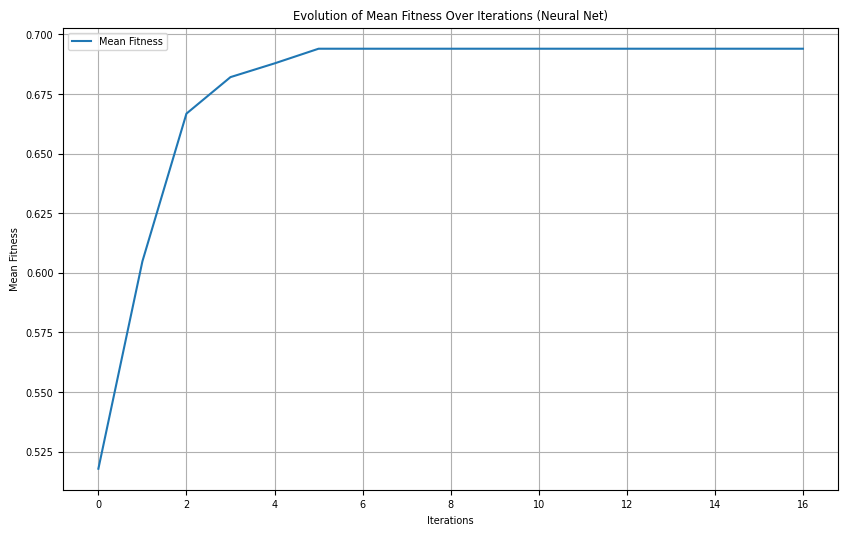

In [8]:
import matplotlib.pyplot as plt

# Compute mean fitness over all instances+restarts for each iteration
fitness = trajectory.get_fitness().mean(dim=(-1, -2))

# Plot the mean fitness over number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(fitness.numel()), fitness.cpu().numpy(), label='Mean Fitness')
plt.xlabel('Iterations')
plt.ylabel('Mean Fitness')
plt.title('Evolution of Mean Fitness Over Iterations (Neural Net)')
plt.legend()
plt.grid(True)
plt.show()

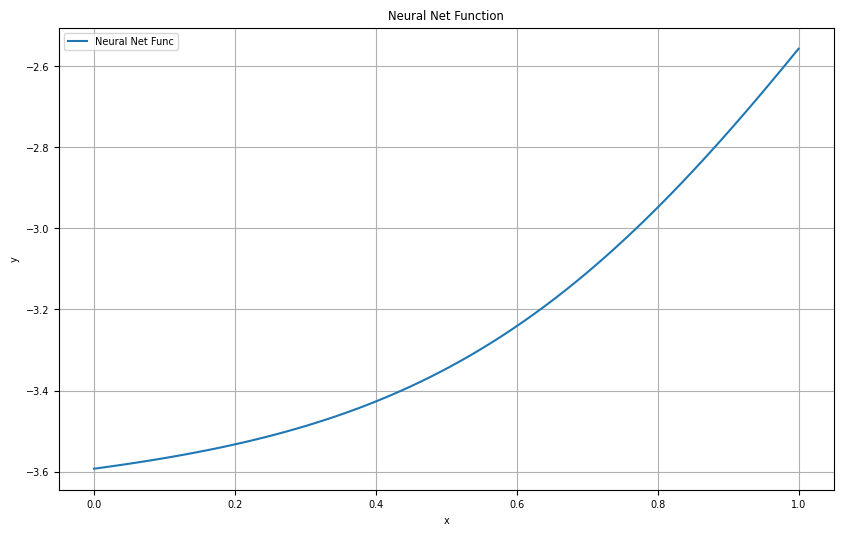

In [9]:
with torch.no_grad():
  x = torch.linspace(0, 1, steps=100, device=device).unsqueeze(-1)
  y = val_model(x)

plt.figure(figsize=(10, 6))
plt.plot(x.cpu().numpy(), y.cpu().numpy(), label='Neural Net Func')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Neural Net Function')
plt.legend()
plt.grid(True)
plt.show()

torch.Size([17])


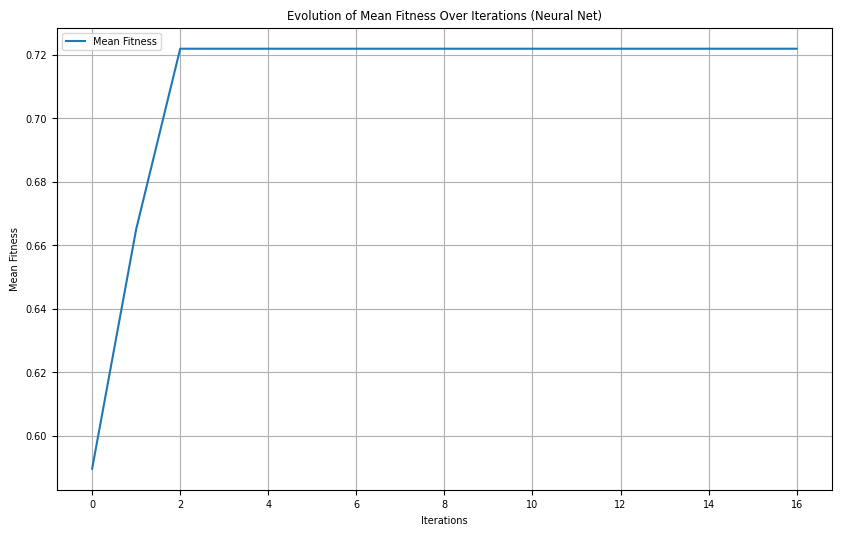

In [10]:
import matplotlib.pyplot as plt

# Compute mean fitness over all instances+restarts for each iteration
fitness = trajectory.get_fitness()[:, 0, 0]
print(fitness.shape)

# Plot the mean fitness over number of iterations
plt.figure(figsize=(10, 6))
plt.plot(range(fitness.numel()), fitness.cpu().numpy(), label='Mean Fitness')
plt.xlabel('Iterations')
plt.ylabel('Mean Fitness')
plt.title('Evolution of Mean Fitness Over Iterations (Neural Net)')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
best_weights = evo_strategy.result[0]
torch.save(best_weights, f"weights_1-10-5-1_{n}_{k}_{max_generations}.pt")

In [12]:
sum.__module__

'numpy'